### Import Library

In [1]:
import os
import pandas as pd
import torch
from argparse import Namespace
from torch.utils.data import DataLoader

import sys
sys.path.insert(1, "/Users/yeojisu/Documents/House-Price-Index-Prediction")

from config.config_US import *
from model.dfm_model import * 
from model.var_model import *
from model.kalman_filter import *
from utils.deep_learning import *
from utils.data_loader import *
from utils.visualization import *
from baseline.recent.xPatch import Model # Choose xPatch for Residual Learning 

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency information")
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Load Data

In [2]:
target_df = load_target_data_us(TARGET_PATH)
target_df_train = target_df[target_df.index < TEST_DATE]
target_df_test  = target_df[target_df.index >= TEST_DATE]

### Dynamic Factor Model (DFM)

In [ ]:
dfm_results = run_dfm(target_df_train, target_df_test, REFERENCE_DATE, 5)
# train phase 
optimal_factors = dfm_results["optimal_factors"]
shared_component_final_train = dfm_results["shared_component_final_train"]
loadings     = dfm_results["loadings"]
scale_factor = dfm_results["scale_factor"]
offset       = dfm_results["offset"]

combined_array = dfm_results["combined_shared_component"]

factor_column_list = []
for i in range(optimal_factors):
    factor_column_list.append("factor"+str(i+1))

factor_df = pd.DataFrame(combined_array, columns=factor_column_list, index=target_df.index)


Number of common factors 1: AIC = 13243.10
Number of common factors 2: AIC = 12781.00
Number of common factors 3: AIC = 12787.34
Number of common factors 4: AIC = 13762.82
Number of common factors 5: AIC = 14158.24

Optimal number of common factors: 2
Optimization terminated successfully.
         Current function value: 23.054809
         Iterations: 37
         Function evaluations: 25634


In [4]:
df = load_feature_data_us(FEATURE_PATH, FEATURE_COLUMN, TRAIN_DATE)
df = pd.concat([df, factor_df], axis=1)
df = df.dropna()


### Vector Autoregression (VAR)

{'call_rate': 21, 'bond_10yr': 22, 'M1_velocity': 22, 'M2_real': 23, 'CPI': 17, 'inflation': 23, 'employee': 1, 'total_construction': 22, 'IPI_supply': 5, 'house_supply': 2, 'factor2': 1}


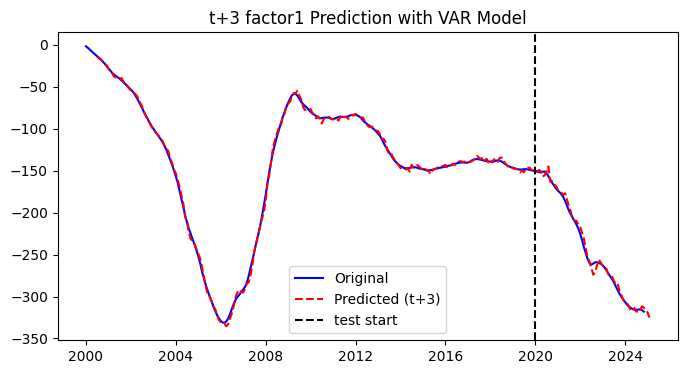

{'call_rate': 19, 'bond_10yr': 22, 'NASDAQ': 7, 'M1_velocity': 23, 'M2_real': 6, 'M2_velocity': 5, 'financial': 21, 'nonfinancial': 22, 'CPI': 23, 'inflation': 22, 'GDP': 23, 'total_construction': 1, 'IPI_supply': 1, 'house_supply': 19, 'factor1': 23}


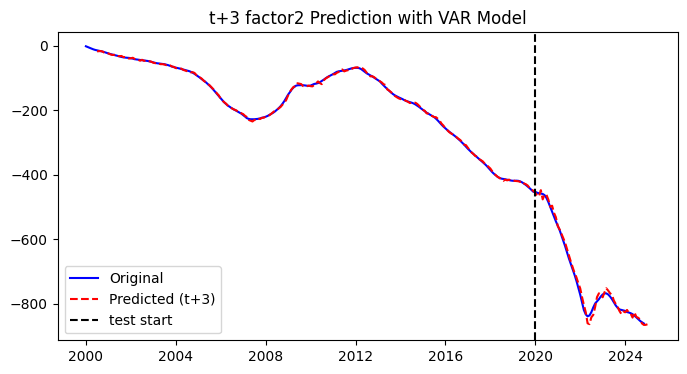

In [5]:
forecast_dfs = {} 
for i in range(optimal_factors):
    factor_name = f"factor{i+1}"
    
    forecast_dfs[factor_name] = var_forecast(df, factor_name, TEST_DATE, MAXLAG_FACTOR, SELECTED_LAG_FACTOR, FORECAST_HORIZON)
    
    plot_var_forecast(df, forecast_dfs[factor_name], factor_name, TEST_DATE, FORECAST_HORIZON)

### Kalman Filter

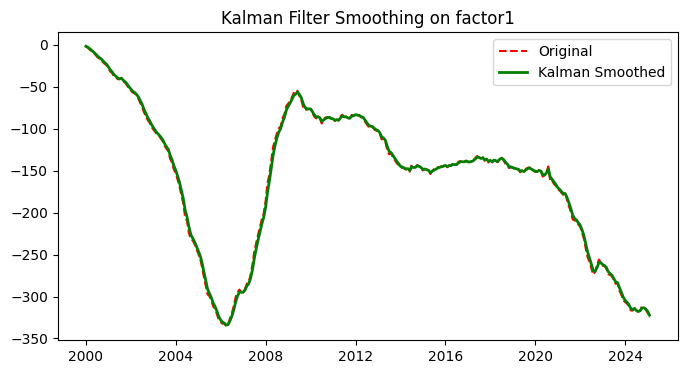

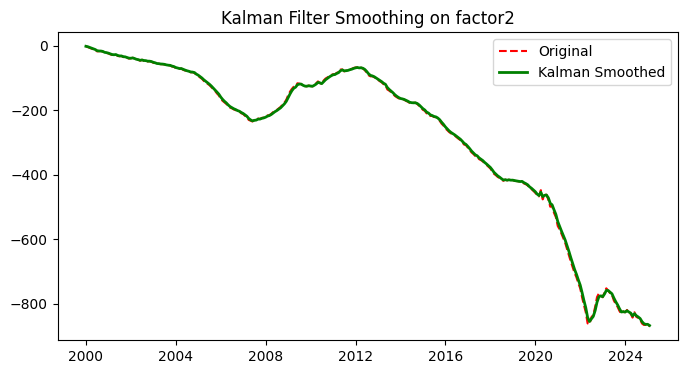

In [6]:
smoothed_factors = {} 
for i in range(optimal_factors):
    factor_name = f"factor{i+1}"
    combined_series = pd.concat([df[factor_name][TRAIN_DATE:TRAIN_DATE[:6]+str(FORECAST_HORIZON+SELECTED_LAG_FACTOR)+'-15'], forecast_dfs[factor_name][factor_name]])
    smoothed = apply_kalman_filter(combined_series, KALMAN_OBSERVATION_COV, KALMAN_TRANSITION_COV)
    plot_kalman_filter_result(combined_series, smoothed, factor_name)
    smoothed_factors[factor_name] = smoothed


### ✅ Deep Residual Learning (xPatch)

In [7]:
smoothed_factors_df = pd.concat(list(smoothed_factors.values()), axis=1)
smoothed_factors_df.columns = [f"factor{i+1}" for i in range(optimal_factors)]

common_index = target_df.index.intersection(smoothed_factors_df.index)
smoothed_factors_df = smoothed_factors_df.loc[common_index]
target_df_common = target_df.loc[common_index]

target_mean = target_df_train.mean().values
factors_adjusted = (smoothed_factors_df.values @ loadings.T) * scale_factor + target_mean + offset

resid = target_df_common - factors_adjusted
resid = resid.reset_index().rename(columns={"index": "Date"})
resid["Date"] = pd.to_datetime(resid["Date"])

100%|██████████| 1000/1000 [03:57<00:00,  4.21it/s]


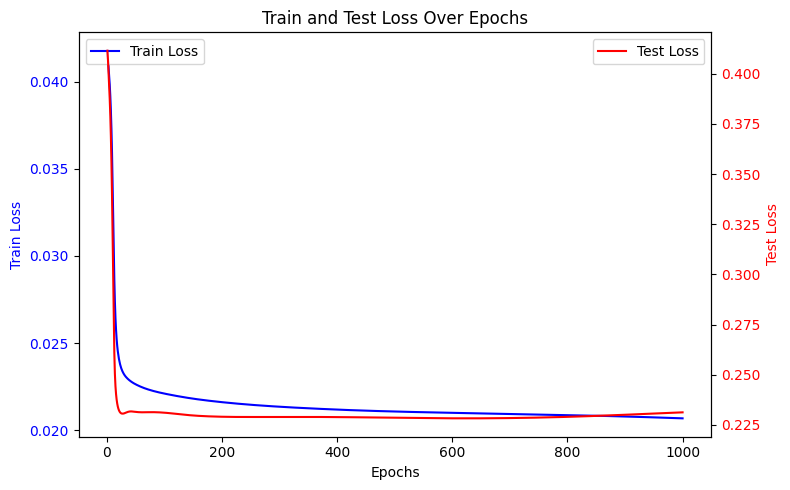

In [8]:
window_size  = WINDOW_SIZE
forecast_size = FORECAST_HORIZON
idx = resid[resid['Date'] == pd.to_datetime(TEST_DATE)].index[0]
train_df = resid.iloc[:idx]
test_df  = resid.iloc[idx - (forecast_size + window_size):].reset_index(drop=True)

columns_to_use = resid.columns.drop("Date")
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, "Date", columns_to_use)
train_x, train_y, train_date_list = time_slide_df(train_df_fe, window_size, forecast_size, "Date", columns_to_use)
test_x, test_y, test_date_list   = time_slide_df(test_df_fe, window_size, forecast_size, "Date", columns_to_use)

configs = Namespace(
    seq_len      = window_size,
    pred_len     = forecast_size,
    ker_len      = 25,
    enc_in       = len(columns_to_use),
    patch_len    = 3,
    stride       = 2,
    padding_patch= 'end',
    revin        = True,
    ma_type      = 'ema',
    alpha        = 0.3,
    beta         = 0.3,
    use_patch    = True,
    patch_size   = 3,
)
train_ds = Data(train_x, train_y)
test_ds  = Data(test_x, test_y)
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=len(test_df), shuffle=False)

model = Model(configs=configs)
criterion = torch.nn.MSELoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 1000
patience   = 20
save_path  = os.path.join(DIR_PATH, f"model{VERSION}.pth")

train_loss_list, test_loss_list = train_deep_learning_model(model, train_dl, test_dl, criterion, optimizer, num_epochs, patience, save_path)
plot_loss_curve(train_loss_list, test_loss_list)



Draw the Results

SanFrancisco_HPI: RMSE=8.909, MAE=6.25
LosAngeles_HPI: RMSE=8.383, MAE=5.60099983215332
Seattle_HPI: RMSE=8.061, MAE=5.541999816894531
SanDiego_HPI: RMSE=8.379, MAE=6.296000003814697
Chicago_HPI: RMSE=2.065, MAE=1.5920000076293945
Dallas_HPI: RMSE=5.845, MAE=4.5269999504089355
NewYork_HPI: RMSE=3.66, MAE=2.9200000762939453
Phoenix_HPI: RMSE=4.907, MAE=3.86299991607666
Boston_HPI: RMSE=4.049, MAE=3.2149999141693115
Miami_HPI: RMSE=5.01, MAE=3.625
Denver_HPI: RMSE=4.324, MAE=3.253000020980835
Atlanta_HPI: RMSE=2.541, MAE=1.8420000076293945
LasVegas_HPI: RMSE=4.152, MAE=3.1489999294281006
Tampa_HPI: RMSE=4.626, MAE=3.5329999923706055
Portland_HPI: RMSE=5.404, MAE=3.9679999351501465
Washington_HPI: RMSE=4.079, MAE=2.990000009536743
Charlotte_HPI: RMSE=4.444, MAE=3.6440000534057617
Detroit_HPI: RMSE=2.067, MAE=1.6369999647140503
Minneapolis_HPI: RMSE=2.163, MAE=1.753000020980835
Cleveland_HPI: RMSE=3.286, MAE=2.7769999504089355


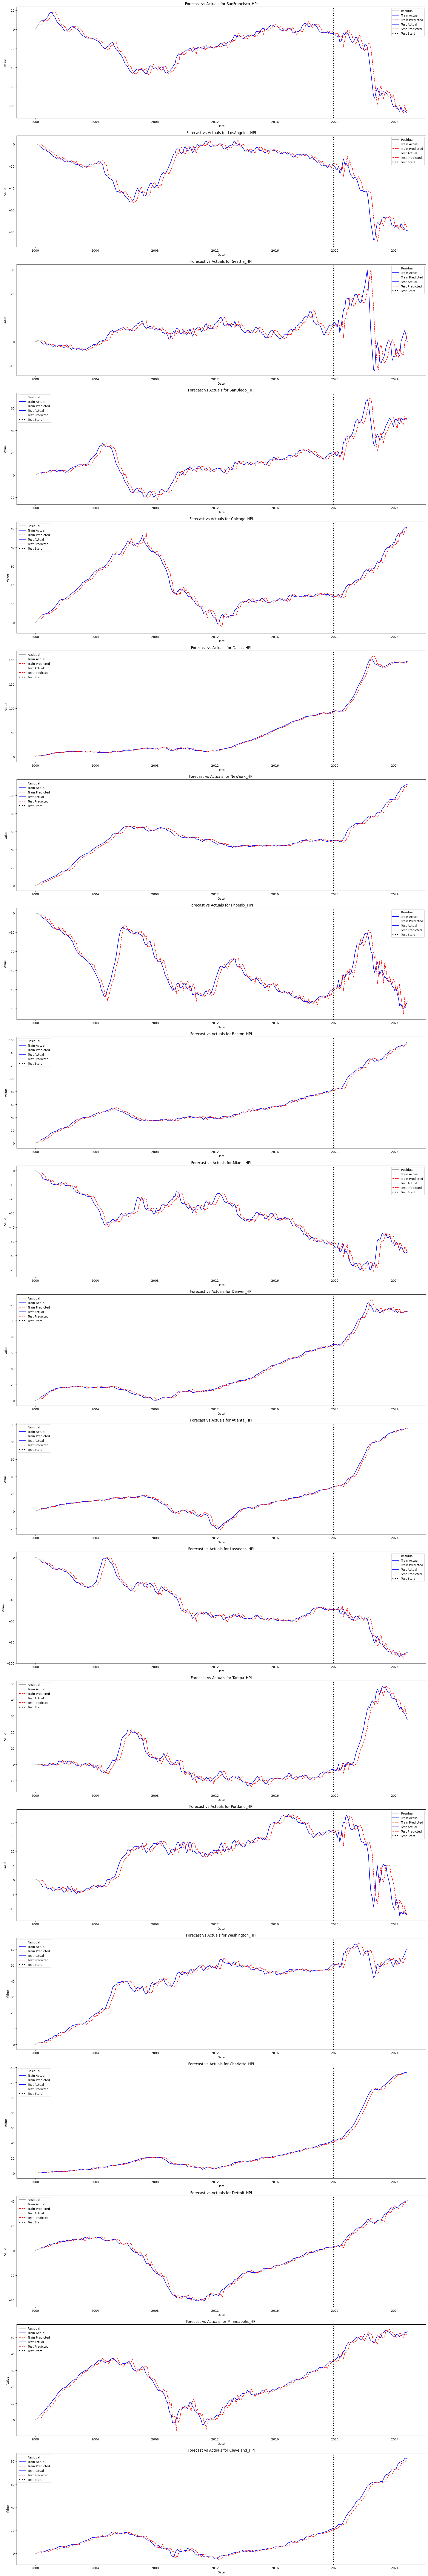

In [9]:
model.load_state_dict(torch.load(save_path))
model.eval()

train_outputs, train_targets = evaluate_model(model, DataLoader(train_ds, batch_size=len(train_ds), shuffle=False))
test_outputs, test_targets   = evaluate_model(model, DataLoader(test_ds, batch_size=len(test_ds), shuffle=False))

train_predicted = train_outputs[:, -1, :].cpu().numpy()
train_actual    = train_targets[:, -1, :].cpu().numpy()
train_dates = train_date_list[:, -1] 

test_predicted  = test_outputs[:, -1, :].cpu().numpy()
test_actual     = test_targets[:, -1, :].cpu().numpy()
test_dates = test_date_list[:, -1] 

plot_deep_learning_results(resid, columns_to_use, train_dates, test_dates,
                           train_actual, train_predicted, test_actual, test_predicted,
                           mean_, std_)


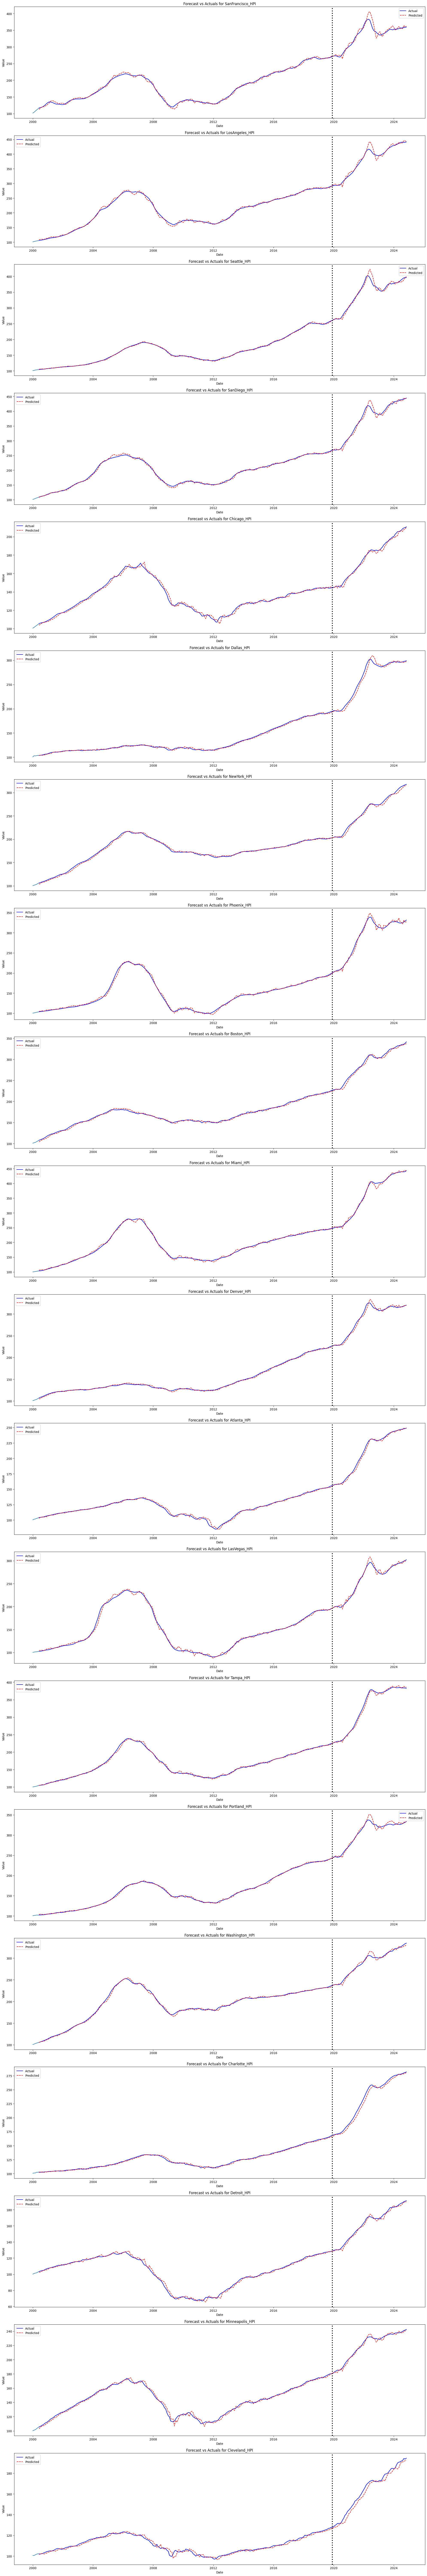

In [10]:
additional_test_x, additional_test_y, additional_test_date = test_time_slide_df(test_df_fe, window_size, forecast_size, "Date", columns_to_use)
addi_test_ds = Data(additional_test_x, additional_test_y)
addi_test_dl  = DataLoader(addi_test_ds, batch_size=len(additional_test_x), shuffle=False)
with torch.no_grad():
    for data, target in addi_test_dl:
        addi_test_output = model(data)
        addi_test_predicted = addi_test_output[:, -1, :].cpu().numpy() 

f = (pd.concat(smoothed_factors,axis=1).values @ loadings.T) * scale_factor + target_df_train.mean().values + offset
f_pd_all = pd.DataFrame(f, index=pd.to_datetime(smoothed_factors['factor1'].index), columns=target_df.columns)

plot_additional_test_predictions(target_df, columns_to_use,
                                 train_actual, train_predicted,
                                 test_actual, test_predicted,
                                 addi_test_predicted,
                                 train_dates, test_dates,
                                 mean_, std_, f_pd_all, forecast_size)